<div class="title">Aplicaciones de Análisis &ndash; TensorFlow: Práctica</div>
<div class="subtitle">Máster en Big Data y Data Science</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---

<div style="font-size: large; font-weight: bold; margin-left: 2em;">Nombre: Javier Muñoz Haro</div>

**Configuración Inicial**

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

# Enunciado

## Introducción

Se dispone de un conjunto de imágenes etiquetadas como: `cloudy`, `rain`, `shine`, y `sunrise`.

## Objetivo

<div class="qst">

* Crear un modelo con Keras que permita determinar, a partir de una imagen de test, la etiqueta correcta.
    * Se requiere una precisión mínima de entrenamiento del $94\%$. Llegado a este punto se deberá parar el entrenamiento.
    * Dada la complejidad del problema, se deberá:
        * Probar diferentes optimizadores.
        * Probar diferentes tasas de aprendizaje.
        * Variar el número de épocas, el tamaño de los *batchs*, el número de pasos por época...
        * Utilizar diferentes *callbacks* para facilitar la experimentación (por ejemplo, guardando los modelos según se va avanzando).
    * Para cada una de estas comprobaciones, se deberá dar una breve explicación de su funcionamiento y de los resultados obtenidos.

</div>

# Dependencias

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow import keras

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(15, 5))

# Esquema

El *notebook* está organizado mostrando un posible ejemplo de la ruta que se puede seguir para afrontar el problema (aunque no es estrictamente necesario seguir este orden).

Como *baseline* y punto de partida, se realiza la carga de los datos, y se entrena un modelo lineal (perceptrón de clasificación).

## Carga de Datos y Preproceso

* Cargar las imágenes.
* Preprocesar las imágenes.
    * Normalizar la escala.
    * Garantizar que el tamaño sea coherente.
* Generar nuevos ejemplos.
* Ajustar tamaño de *batch*.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters.
rescale = 1. / 255
image_size = (150, 150)
batch_size = 32

# The image generator can help to preprocess the images.

# In training, new samples can be generated by modifying this object.
datagen_tr = ImageDataGenerator(
    rescale=rescale
)
# In test (and validation), new samples should not be added.
datagen_te = ImageDataGenerator(
    rescale=rescale
)

# The data is already partitioned by folders, each class is in a different subfolder.
# The following function returns iterators to each dataset.
data_tr = datagen_tr.flow_from_directory(
    "data/train/",
    target_size=image_size,
    batch_size=batch_size
)
data_va = datagen_te.flow_from_directory(
    "data/validation/",
    target_size=image_size,
)
data_te = datagen_te.flow_from_directory(
    "data/test/",
    target_size=image_size,
)

Found 900 images belonging to 4 classes.
Found 111 images belonging to 4 classes.
Found 114 images belonging to 4 classes.


* Ejemplo del conjunto de datos.

Batch shape (input):  (32, 150, 150, 3)
Batch shape (target): (32, 4)


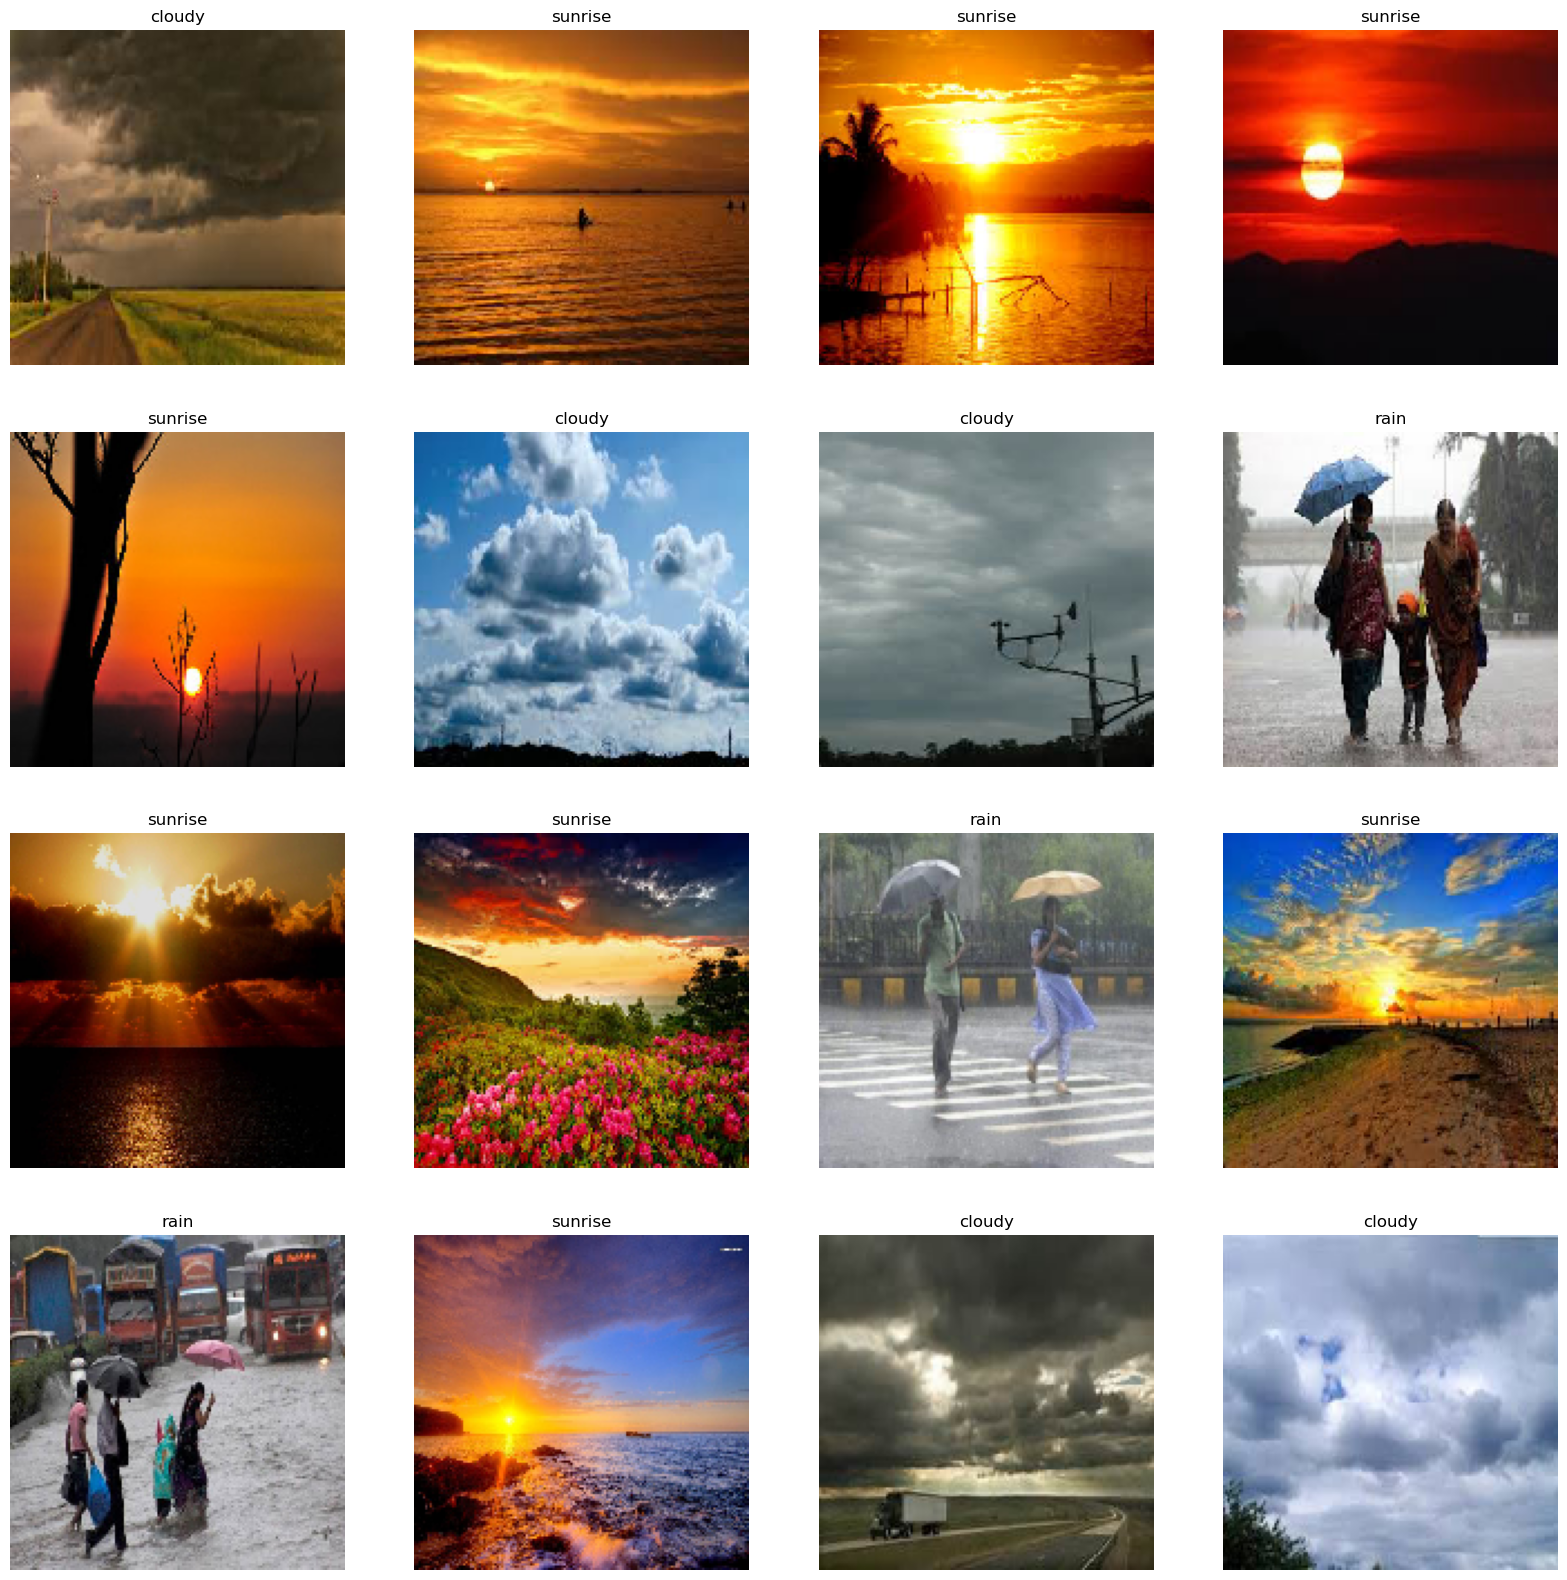

In [4]:
classes = [k for k, v in data_tr.class_indices.items()]

n_rows = 4
n_cols = 4

for batch_x, batch_y in data_tr:
    print("Batch shape (input): ", batch_x.shape)
    print("Batch shape (target):", batch_y.shape)

    plt.figure(figsize=(20, 20))
    for c, x, y in zip(range(len(batch_x)), batch_x, batch_y):
        if c == n_rows * n_cols:
            break

        plt.subplot(n_rows, n_cols, c + 1)
        plt.imshow(x)
        plt.axis("off")
        plt.title(classes[np.where(y)[0][0]])

    plt.show()
    break

## Definición del Modelo

* Ajustar arquitectura.

In [5]:
# A simple perceptron is defined in this case.
model = keras.Sequential(
    [
        keras.layers.Input(shape=(image_size[0], image_size[1], 3)),

        # Data augmentation: estamos creando mas ejemplos que pasarle a la red para entrenar mas escenarios
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.BatchNormalization(),

        # Capas ocultas
        keras.layers.Conv2D(128, kernel_size=(4, 4), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 3)),
        keras.layers.Conv2D(256, kernel_size=(4, 4), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 3)),
        keras.layers.Flatten(),
        
        # Eliminamos las conexiones entre la capa de activación y la de salida para evitar overfitting
        keras.layers.Dropout(0.5),
        
        # Capa de salida
        keras.layers.Dense(4, activation="softmax")
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 147, 147, 128)     6272      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 128)      0         
 )                                                               
                                                        

## Compilación del Modelo

* Ajustar optimizador.
* Ajustar tasa de aprendizaje.

In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## Entrenamiento del Modelo

* Definir *callbacks*.
* Ajustar número de épocas.
* Ajustar el número de pasos por época.

In [7]:
# Creamos un callback customizado que pare cuando la val_accuracy > 94%
from keras.callbacks import EarlyStopping, ModelCheckpoint

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [8]:
epochs = 200
PATH = "./tmp/BestModel/"
bst_model_path = PATH + "best_weights.h5"

callbacks = [
    MyThresholdCallback(threshold=0.94),
    # ModelCheckpoint(filepath = bst_model_path, save_best_only=True, save_weights_only=True, monitor="accuracy")
]

history = model.fit(
    data_tr,
    validation_data=data_va,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/200
29/29 [==============================] - 14s 339ms/step - loss: 0.7444 - accuracy: 0.7289 - val_loss: 0.6455 - val_accuracy: 0.7928
Epoch 2/200
29/29 [==============================] - 10s 329ms/step - loss: 0.4016 - accuracy: 0.8589 - val_loss: 0.4749 - val_accuracy: 0.8649
Epoch 3/200
29/29 [==============================] - 10s 335ms/step - loss: 0.4039 - accuracy: 0.8589 - val_loss: 0.4648 - val_accuracy: 0.8288
Epoch 4/200
29/29 [==============================] - 9s 315ms/step - loss: 0.2776 - accuracy: 0.9033 - val_loss: 0.3418 - val_accuracy: 0.8919
Epoch 5/200
29/29 [==============================] - 9s 317ms/step - loss: 0.3629 - accuracy: 0.8744 - val_loss: 0.2711 - val_accuracy: 0.9189
Epoch 6/200
29/29 [==============================] - 9s 314ms/step - loss: 0.4154 - accuracy: 0.8489 - val_loss: 0.2697 - val_accuracy: 0.9099
Epoch 7/200
29/29 [==============================] - 10s 324ms/step - loss: 0.3032 - accuracy: 0.8967 - val_loss: 0.3345 - val_accuracy: 0.

## Evaluación del Resultado

* Analizar los errores en entrenamiento y test finales.
* Analizar la evolución de los errores durante el entrenamiento, tanto sobre el conjunto de entrenamiento como sobre el de validación.
* Comprobar el resultado sobre algunas imágenes de forma manual.

In [9]:
#model.load_weights(bst_model_path)
[loss, acc] = model.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 92.11%


In [10]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

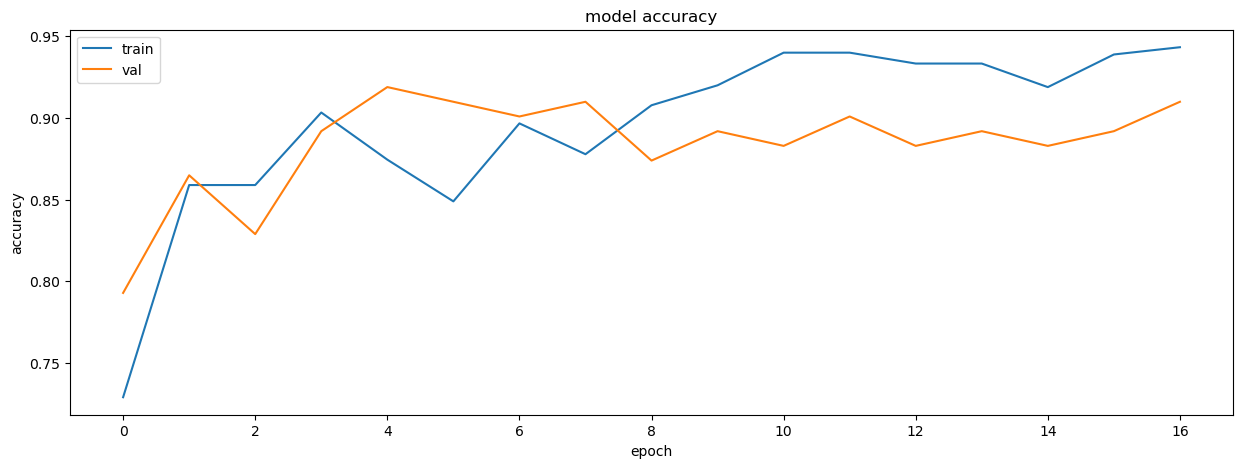

In [12]:
plot_accuracy(history)

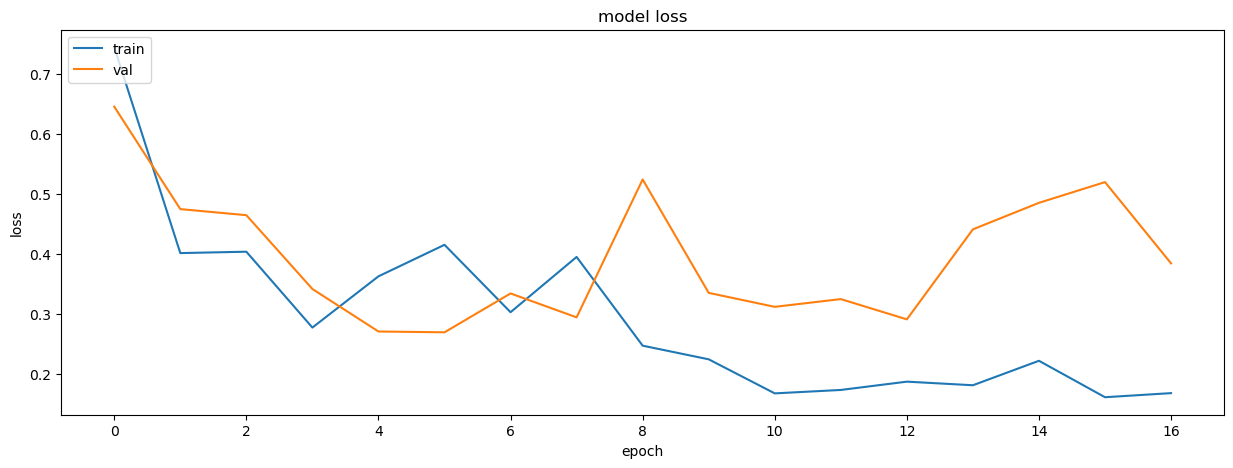

In [13]:
plot_loss(history)

## Testeo de predicciones del modelo

In [14]:
def cast_to_pretty_class(predictions):
    predicted_class_indices=np.argmax(predictions,axis=1)
    labels = (data_te.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    return predictions

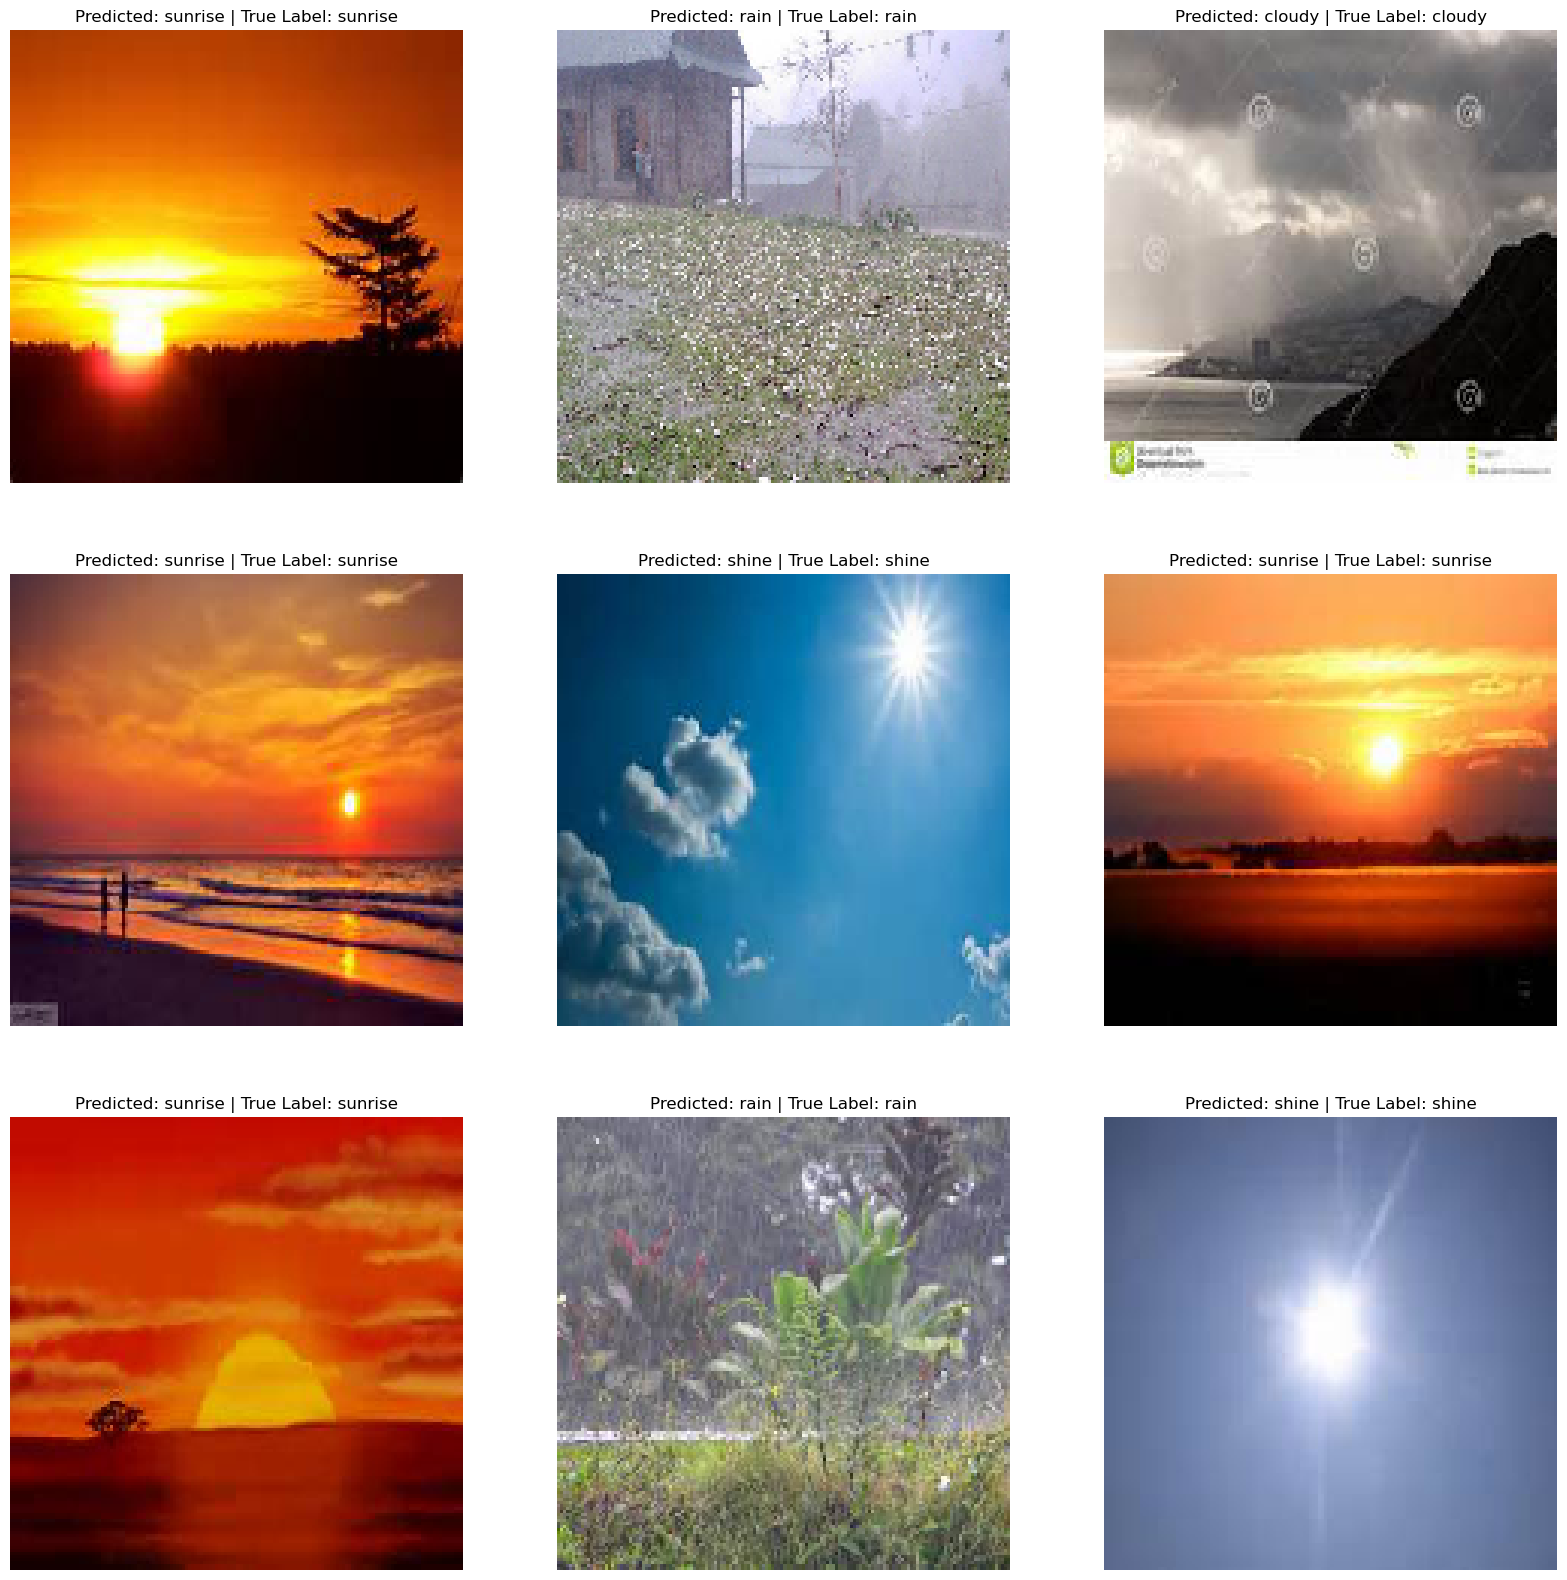

In [15]:
BATCH_INDEX = 0 # get all the batchs
IMG_OR_LBL = 0 # 0 to get the imgs 1 to get de labels
INDEX_IN_BATCH = 0 # get the nth element in the batch (depending on the value you give to the IMG_OR_LBL, it will give you the image or de true label)


test_images = data_te[BATCH_INDEX][0]
test_labels = data_te[BATCH_INDEX][1]

n_rows = 3
n_cols = 3

samples_index = np.random.choice(range(32), n_rows*n_cols, replace=False)

plt.figure(figsize=(20, 20))
j=0
for i in samples_index:
    image_test = test_images[i]
    true_label = list(data_te.class_indices.keys())[np.argmax(test_labels[i],axis=0)]
    img = (np.expand_dims(image_test,0))
    predict_single = model.predict(img, verbose=0)

    plt.subplot(n_rows, n_cols, j + 1)
    plt.imshow(x)
    plt.axis("off")
    plt.title("Predicted: " + cast_to_pretty_class(predict_single)[0] + " | True Label: " + true_label)

    plt.imshow(image_test)
    j+=1

plt.show()

#### __Matriz de confusión__

Para tener una mejor óptica de como predice nuestro modelo, vamos a plottear la matriz de confusión entre las etiquetas reales y las predichas por nuestro modelo y ver que tal se comporta.

In [16]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

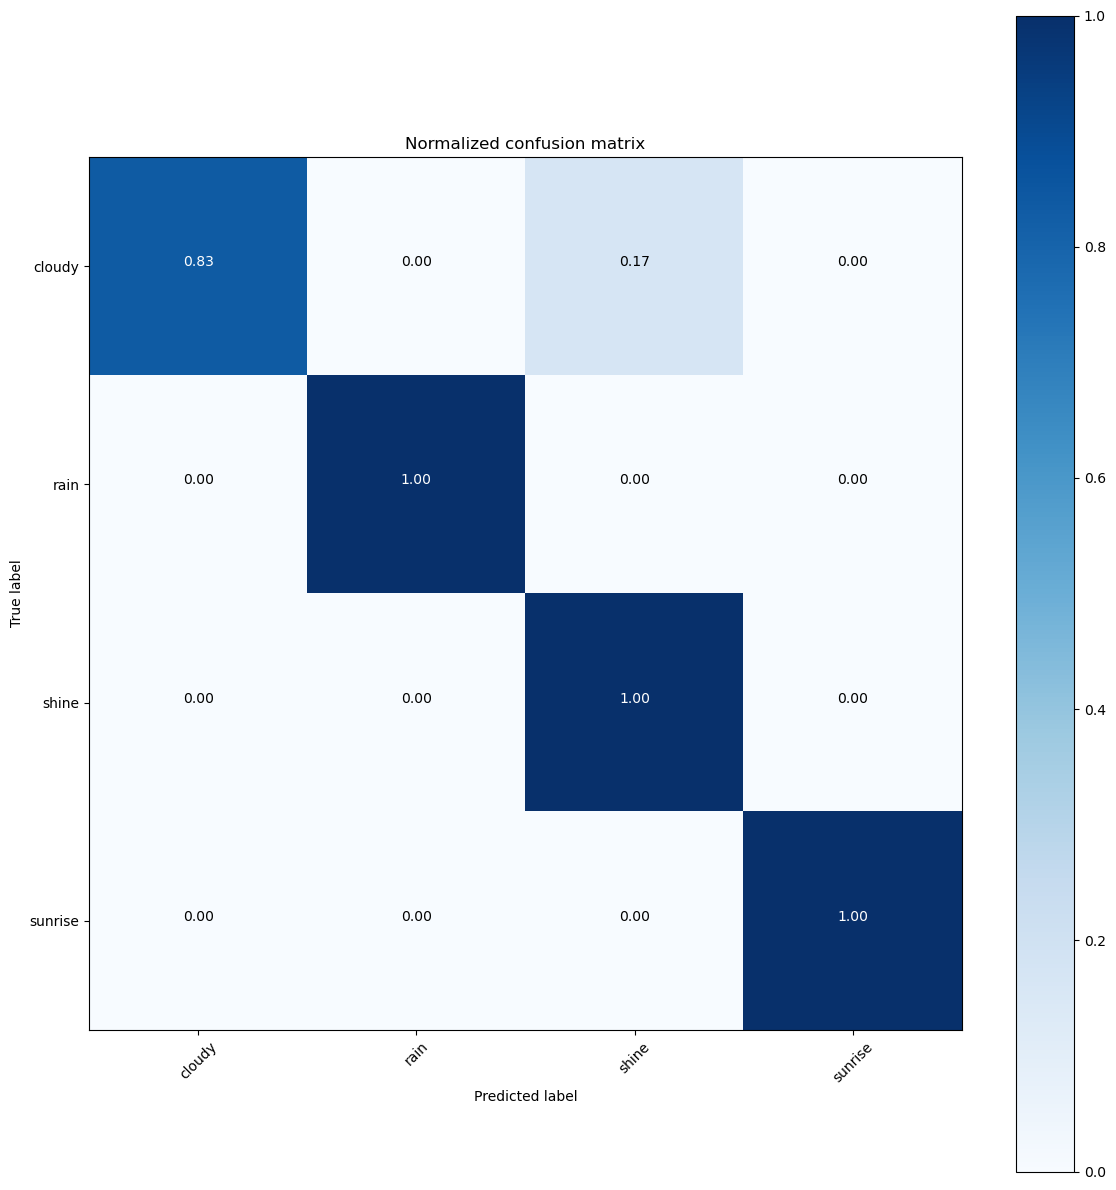

In [17]:
predict_labels = model.predict(test_images, verbose=0)

true_labels = []
for label in test_labels:
    true_labels.append(list(data_te.class_indices.keys())[np.argmax(label, axis=0)])

pred_labels = []
for predicted_label in predict_labels:
    pred_labels.append(list(data_te.class_indices.keys())[np.argmax(predicted_label,axis=0)])


cnf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=["cloudy", "rain", "shine", "sunrise"], normalize=True, title='Normalized confusion matrix')
plt.show()

Como se puede observar, existe un buen porcentaje de clases en las que nuestro modelo clasifica correctamente. Vemos que si que hay una pequeña confusión en el caso de las imágenes de tipo "cloudy", ya que el modelo, a veces, predice estas como shine. Observando el dataset, si que vemos que en efecto, existen ocasiones en las que las fotos catalogadas como shine, tienen nubes y la foto no es muy brillante, de ahí creemos que exista esta confsuión por parte de nuestro modelo.